# Capacidad de alojamiento

## Ejemplos

**Ejemplo 6.19:**

In [ ]:
!pip install pandapower['all']

In [ ]:
import pandapower as pp
net = pp.create_empty_network()  # Red vacía

# Barras (nodos)
bus1 = pp.create_bus(net, vn_kv=20., name="Barra 1")
bus2 = pp.create_bus(net, vn_kv=0.4, name="Barra 2")

# Generación (Slack bus)
pp.create_ext_grid(net, bus=bus1, vm_pu=1.0, name="Red Externa")

# Cargas
pp.create_load(net, bus=bus2, p_mw=0.1, q_mvar=0.05, name="Carga Residencial")

# Líneas
pp.create_line(net, from_bus=bus1, to_bus=bus2, length_km=0.5,
               std_type="NAYY 4x50 SE", name="Línea 1")

# Transformadores
pp.create_transformer(net, hv_bus=bus1, lv_bus=bus2,
                     std_type="0.63 MVA 20/0.4 kV", name="Trafo 1")

In [ ]:
# Creación de barras con diferentes niveles de voltaje
bus_slack = pp.create_bus(net, vn_kv=115, name="Slack Bus", type="b")
bus_pv = pp.create_bus(net, vn_kv=23, name="PV Bus", type="b")
bus_pq = pp.create_bus(net, vn_kv=0.48, name="PQ Bus", type="b")

# Visualizar barras creadas
print(net.bus)

In [ ]:
pp.create_ext_grid(net, bus=bus_slack, vm_pu=1.02, name="Subestación Principal",
                  max_p_mw=100, min_p_mw=0, max_q_mvar=50, min_q_mvar=-50)
print(net.ext_grid)

In [ ]:
# Diferentes tipos de carga
pp.create_load(net, bus=bus_pq, p_mw=1.5, q_mvar=0.75, name="Residencial",
               const_z_percent=0, const_i_percent=100)  # Corriente constante

pp.create_load(net, bus=bus_pq, p_mw=5.0, q_mvar=2.5, name="Comercial",
               const_z_percent=100, const_i_percent=0)  # Impedancia constante

# Carga con factor de potencia
pp.create_load_from_cosphi(net, bus=bus_pq, sn_mva=3.0, cos_phi=0.9,
                           name="Industrial", mode="underexcited")

In [ ]:
# Creación de líneas con tipos estándar
line1 = pp.create_line(net, from_bus=bus_slack, to_bus=bus_pv, length_km=15,
                       std_type="149-AL1/24-ST1A 10.0", name="Línea Tronsmisión")

# Línea con parámetros personalizados
line2 = pp.create_line_from_parameters(
    net, from_bus=bus_pv, to_bus=bus_pq, length_km=0.2, name="Línea Distribución",
    r_ohm_per_km=0.162, x_ohm_per_km=0.083, c_nf_per_km=235, max_i_ka=0.142)

print(net.line)

In [ ]:
# Transformador estándar
trafo1 = pp.create_transformer(
    net, hv_bus=bus_slack, lv_bus=bus_pv, name="Trafo Principal",
    std_type="25 MVA 110/20 kV")

# Transformador con tap variable
trafo2 = pp.create_transformer_from_parameters(
    net, hv_bus=bus_pv, lv_bus=bus_pq, name="Trafo Distribución",
    sn_mva=0.63, vn_hv_kv=23, vn_lv_kv=0.48, vkr_percent=4.5,
    vk_percent=12, pfe_kw=1.5, i0_percent=0.3, tap_pos=0,
    tap_neutral=0, tap_min=-2, tap_max=2, tap_step_percent=1.5)

In [ ]:
pp.create_gen(net, bus=bus_pv, p_mw=2.0, vm_pu=1.02, name="Generador Diésel",
              min_p_mw=0, max_p_mw=3, min_q_mvar=-1, max_q_mvar=1)

In [ ]:
pp.create_sgen(net, bus=bus_pq, p_mw=0.5, q_mvar=0, name="Solar PV",
               type="PV", k=1.2, rx=0.4, current_source=True)

**Ejemplo 6.20:**

In [ ]:
import pandapower as pp

def violations(net):
    pp.runpp(net)
    if net.res_line.loading_percent.max() > 50:
        return (True, "Línea Sobrecargada")
    elif net.res_trafo.loading_percent.max() > 50:
        return (True, "Transformador \n Sobercargado")
    elif net.res_bus.vm_pu.max() > 1.04:
        return (True, "Problemas \n Tensión")
    else:
        return (False, None)

In [ ]:
from numpy.random import choice

def chose_bus(net):
    return choice(net.load.bus.values)

In [ ]:
from numpy.random import normal

def get_plant_size_mw():
    return normal(loc=0.5, scale=0.05)

In [ ]:
import pandapower.networks as nw
def load_network():
    return nw.mv_oberrhein(scenario="generation")

In [ ]:
import pandas as pd

iterations = 50
results = pd.DataFrame(columns=["instalada", "problema"])

for i in range(iterations):
    net = load_network()
    installed_mw = 0
    while 1:
        violated, violation_type = violations(net)
        if violated:
            results.loc[i] = [installed_mw, violation_type]
            break
        else:
            plant_size = get_plant_size_mw()
            pp.create_sgen(net, chose_bus(net), p_mw=plant_size, q_mvar=0)
            installed_mw += plant_size

**Ejemplo 6.24:**

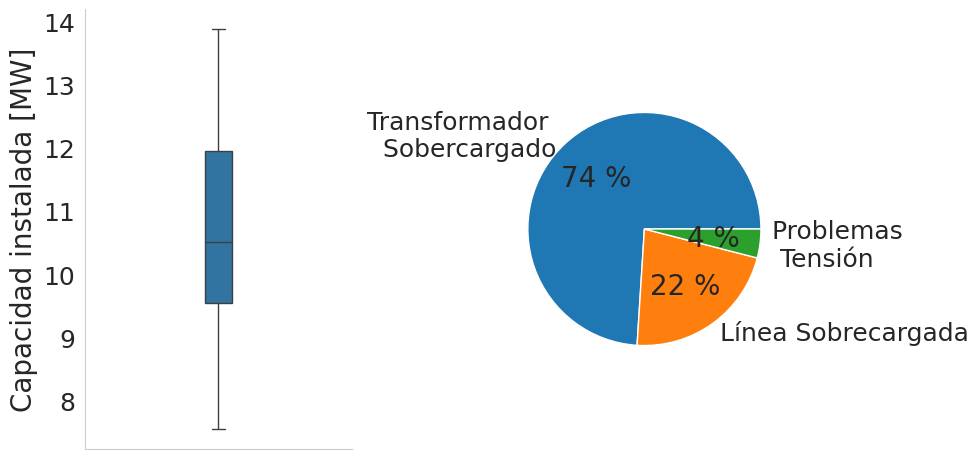

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('axes', labelsize=20)
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = axes[0]
sns.boxplot(results.instalada, width=.1, ax=ax, orient="v")
ax.set_ylabel("Capacidad instalada [MW]") # ¿Cuánta potencia se puede instalar antes de que ocurra un problema?


ax = axes[1]
ax.axis("equal")
results.problema.value_counts().plot(kind="pie", ax=ax,  autopct=lambda x:"%.0f %%"%x)
ax.set_ylabel("")
ax.set_xlabel("")
sns.despine()
plt.tight_layout()